# Проект: 'Предсказание количества визитов в мед.учреждения застрахованных клиентов'    

### Описание проекта

###### Задача:   
На основании характеристик застрахованных и истории их обращений за 2022 год предсказать количество визитов за 2023 год.  

###### Метрика:   
__MSE__  

###### Допущение:   
В Саудовской Аравии на момент периода 2022-2023 действовал МБК-10, идентичный представленному на [сайте](https://classinform.ru/mkb-10.html)

###### Вход:
- ML_train.xlsx - тренировочный сет
- ML_holdout.xlsx - отложенная выборка без ЦП

###### Выход:   
- Рабочий ноутбук или файл .py, содержащий:
    - Код предобработки данных
    - Код обучения модели
    - Код тестирования модели
- Файл .csv с предсказаниями на выборке holdout с указанием ид застрахованного и предсказанием модели
- Список использованных признаков с указанием их значимости
- Комментарии по ходу выполнения задачи  

###### Описание:  
- __Insured_PIN__ - _уникальный ид застрахованного лица_  
- __Insured_Network__ - _Идентификатор сети клиник доступной для застрахованного.   
Network - 1 - клиники с наивысшим уровнем сервиса,   
Network - 8 - клиники с самым базовым уровнем сервиса._
- __Nationality__ - _национальность застрахованного._
- __Gender__ - _пол застрахованного_
- __Relation__ - _в качестве кого застраховано данное лицо. self - работник организации, которая оформляет страховку, child - ребенок застрахованного и т.д._
- __DoB__ - _дата рождения застрахованного_
- __Diagnoses__ - _все диагнозы застрахованного за 2022 год_
- __HasChronicDisease__ - _флаг хронического пациента_
- __Exposition_22__ - _количество дней в 2022 году в которые у данного застрахованного действовал полис медицинского страхования.   
Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2022 год_
- __number_of_visits_22__ - _количество дней в 2022 году в которые застрахованный посещал клинику для получения медицинской помощи_
- __number_of_services_22__ - _количество оказанных медицинских услуг в 2022 году (консультации, анализы, лекарства и т.д.)_
- __Exposition_23__ - _количество дней в 2023 году в которые у данного застрахованного действовал полис медицинского страхования.   
Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2023 год_
- __number_of_visits_23__ - _количество дней в 2023 году в которые застрахованный посещал клинику для получения медицинской помощи._ __Целевой признак__

###### План проекта:   
1. Обзор  
    - Графический анализ 
    - Таргет
2. Обработка
    - Инжиниринг
    - Корреляционный анализ
    - Подготовка данных к моделированию
3. Моделирование  
    - LightGBMRegressor + RSCV
    - Анализ важности признаков
4. Отложенная выборка
    - Обработка
    - Моделирование
4. Общий вывод


### Настройки

In [59]:
# Установки 
#!pip install lightgbm==4.1.0 -q
#!pip install seaborn==0.13.0 -q
#!pip install category_encoders==2.6.3 -q
#!pip install beautifulsoup4==4.12.2 -q
#!pip install pandas==2.1.3 -q
#!pip install numpy==1.26.2 -q
#!pip install matplotlib==3.8.2 -q
#!pip install requests==2.31.0 -q
#!pip install scikit-learn==1.3.2 -q
#!pip install phik==0.12.3 -q

In [60]:
# Импорты
from calendar import month_name as MN
import warnings
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup as bs

from scipy.stats import kruskal
from scipy.stats import mannwhitneyu as u_test

from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import  OrdinalEncoder
from sklearn.metrics import mean_squared_error as MSE

from lightgbm import LGBMRegressor

In [61]:
# Настройки
sns.set_style('darkgrid')
pd.set_option('display.max_columns',300)
warnings.filterwarnings('ignore')

# Константы
RS = 888

In [62]:
# Функции
def get_info(data):
    '''
    Возвращает основную информацию о датасете
    '''
    print(f'Основные показатели датасета:')
    print('-'*40)
    print(f'Количество признаков: {data.shape[1]}')
    print('-'*40)
    print(f'Количество сэмплов: {data.shape[0]}')
    print('-'*40,end='\n\n')
    print('Пример данных:')
    display(data.head(3))
    print('-'*40,end='\n\n')
    print('Описание данных:')
    display(data.describe().T)
    print('-'*40)
    data.info()
    print('-'*40)
    print(f'Процент пропусков в признаках:\n{round(data.isna().sum()/len(data)*100,2)}')
    print('-'*40)
    print(f'Количество дубликатов: {data.index.duplicated().sum()}')
    
def classify_it(data=None, new_cols=None):
    '''
    Относит причину обращения к классификатору МКБ
    '''
    for n in data.index:
        x = data['Diagnoses'][n]
        for col in new_cols:
            for i in x.split(';'):
                if col.split('_')[0] <= i[:3] <= col.split('_')[1]:
                    data[col][n] += 1
    

def processing(model, params, X_train, y_train):
    '''
    Строит пайплан, перебирает гиперпараметры, возвращает 
    обученную модель
    '''

    pipeline = Pipeline([
        ('transformer', transformer),
        ('model', model)
    ])
    
    search = RandomizedSearchCV(pipeline, 
                               param_distributions=params, 
                               n_jobs=-1, cv=8,
                               random_state=RS, 
                               scoring='neg_mean_squared_error')
    
    search.fit(X_train, y_train)
    
    return search

def drawCountplot(feature: 'str', 
                  data = None,
                  squeeze_ticks: int = 5, 
                  need_sort = True):
    '''
    Отрисовывает каунтплот
    '''
    plt.figure(figsize=(16,5))
    
    if need_sort:
        sns.countplot(x=data[feature], 
                      palette='deep', 
                      order=data[feature].value_counts().index) \
                      .set_title(feature, fontsize='x-large')
    else:
        sns.countplot(x=data[feature], 
              palette='deep').set_title(feature, fontsize='x-large')

    if squeeze_ticks:
        plt.xticks([n for n in range(0,data[feature].nunique(),squeeze_ticks)])
        
    plt.xlabel('')
    plt.ylabel('');
    
def drawHistplot(feature: 'str', 
                 data = None,
                 num_bins: 'int' = 100):
    '''
    Отрисовывает гистограмму распределения
    '''
    plt.figure(figsize=(16,5))
    sns.histplot(x=data[feature], 
                  color='darkorange',
                  bins=num_bins).set_title(feature, fontsize='x-large')

    plt.xlabel('')
    plt.ylabel('');    
    
    
def drawSomeHistplots(feature): 
    '''
    Рисует рсапределение таргета в зависимости от значения переменной
    '''
    fig = plt.figure(figsize=(16,10))
    for idx, value in enumerate(data[feature].unique()):
        fig.add_subplot(3,3,idx+1)
        sns.histplot(data.loc[data[feature]==value]['target'], 
                     bins=50)

    plt.suptitle(f'Распределение таргета в зависимости от категории {feature}', y =0.92, fontsize='x-large');

    
def kruskal_test(feature: str, data=None, threshold: int = 0.01):
    ''' 
    Проводит тест Краскелла-Уоллеса на зависимость переменных
    '''
    dick = {}
    for value in data[feature].unique():
        dick[value] = list(data[data[feature] == value]["target"])

    if kruskal(*[dick[key] for key in dick]).pvalue > threshold:  
        data.drop(feature, axis=1, inplace=True)
        print('Признак удален. P-value превышает заданный порог.')
    else:
        print('Краскел и Уоллес настоятельно рекомендуют использовать признак.')
    

### Обзор

In [63]:
try:
    data = pd.read_excel('datasets/ML_train.xlsx', index_col=[0])
except:
    data = pd.read_excel('ML_train.xlsx', index_col=[0])
get_info(data)

Основные показатели датасета:
----------------------------------------
Количество признаков: 12
----------------------------------------
Количество сэмплов: 50000
----------------------------------------

Пример данных:


,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
Insured_PIN,,,,,,,,,,,,
1006786,Network-4,Group 2,Male,Self,1974-04-28,NaN,0,365,0,0,365,0
1008861,Network-2,Saudi,Female,Child,2017-07-27,J20.9;J02,0,365,1,2,365,4
1019055,Network-5,Group 2,Male,Self,1979-02-20,J03.9,0,365,1,4,365,5


----------------------------------------

Описание данных:


,count,mean,min,25%,50%,75%,max,std
DoB,49999,1990-02-22 19:50:30.036600704,1920-03-21 00:00:00,1971-03-23 00:00:00,1991-11-13 00:00:00,2011-04-17 00:00:00,2022-11-12 00:00:00,NaN
HasChronicDisease,50000.0,0.33794,0.0,0.0,0.0,1.0,1.0,0.473013
Exposition_22,50000.0,358.89896,50.0,365.0,365.0,365.0,365.0,35.562003
number_of_visits_22,50000.0,5.74032,0.0,1.0,4.0,8.0,151.0,6.592556
number_of_services_22,50000.0,22.47742,0.0,3.0,13.0,31.0,962.0,29.714146
Exposition_23,50000.0,355.58842,50.0,365.0,365.0,365.0,365.0,43.779065
number_of_visits_23,50000.0,5.89886,0.0,1.0,4.0,8.0,202.0,6.856904


----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 1006786 to 9952098
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_Network        50000 non-null  object        
 1   Nationality            50000 non-null  object        
 2   Gender                 50000 non-null  object        
 3   Relation               50000 non-null  object        
 4   DoB                    49999 non-null  datetime64[ns]
 5   Diagnoses              41226 non-null  object        
 6   HasChronicDisease      50000 non-null  int64         
 7   Exposition_22          50000 non-null  int64         
 8   number_of_visits_22    50000 non-null  int64         
 9   number_of_services_22  50000 non-null  int64         
 10  Exposition_23          50000 non-null  int64         
 11  number_of_visits_23    50000 non-null  int64         
dtypes: datetime64[ns

In [64]:
# Проверка на соответствие отсутствия диагнозов и отсутствия обращений
print(f'Количество пропусков в признаке "диагноз": \
{len(data.loc[data["Diagnoses"].isna()])}', end='\n\n')
      
print(f'Количество пропусков в признаке "количество визитов": \
{len(data.loc[data["number_of_visits_22"] == 0])}', end='\n\n')
      
print(f'Количество совпадений: \
{len(data.loc[data["Diagnoses"].isna()]["number_of_visits_22"])}', end='\n\n')

gain = 100 * ((data['number_of_visits_23'].sum() - 
        data['number_of_visits_22'].sum()) / 
        data['number_of_visits_23'].sum())
      
print(f"Прирост количества обращений составил: {gain:.2f}%") 

Количество пропусков в признаке "диагноз": 8774

Количество пропусков в признаке "количество визитов": 8774

Количество совпадений: 8774

Прирост количества обращений составил: 2.69%


##### Вывод  
1. Датасет представлен 50000 записями и 12 признаками, из которых один - айди пользователя и один - целевой. Итого - 10 рабочих признаков.
2. Имеется один пропуск в дате рождения и 17.5% пропусков в диагнозе.  
3. Пропуски в диагнозе совпадают с нулевыми значениями в признаке количество обращений. Можно поставить заглушку и не удалять пропуски.
4. Дубликаты отсутствуют.
5. Типы данных: object, int и datetime
6. Средние и медианы признаков незначительно различаются за исключением количества оказанных услуг. Это связано с большим количеством нулевых значений.
7. Средний возраст клиента - 23 года
8. Признаки, содержащие категорийные значения: сеть, национальность, пол, отношение, наличие хронических заболеваний, диагноз.
9. Количество обращений выросло на 2.7% год к году.

### Таргет

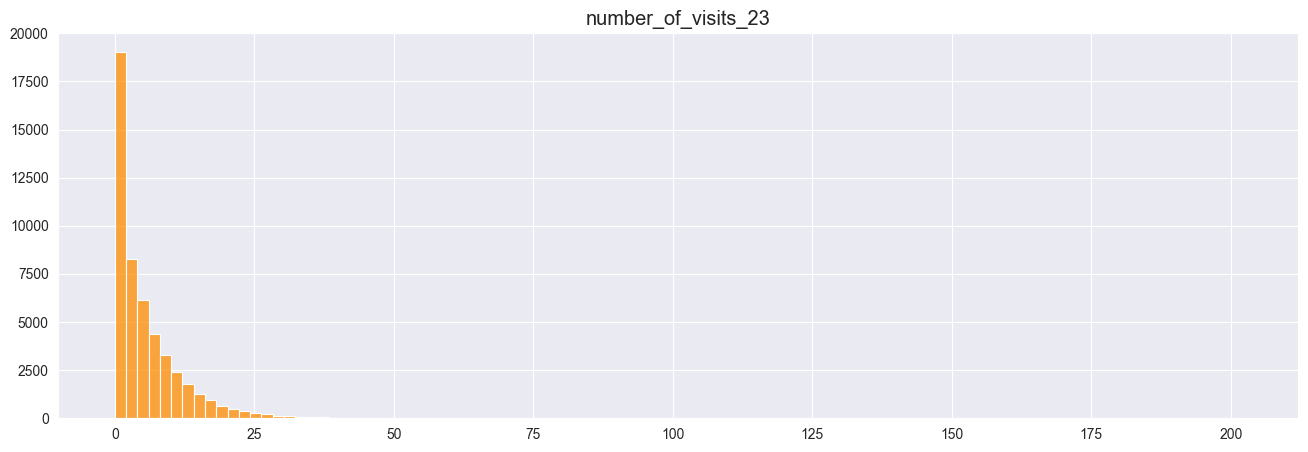

In [65]:
drawHistplot('number_of_visits_23', data)

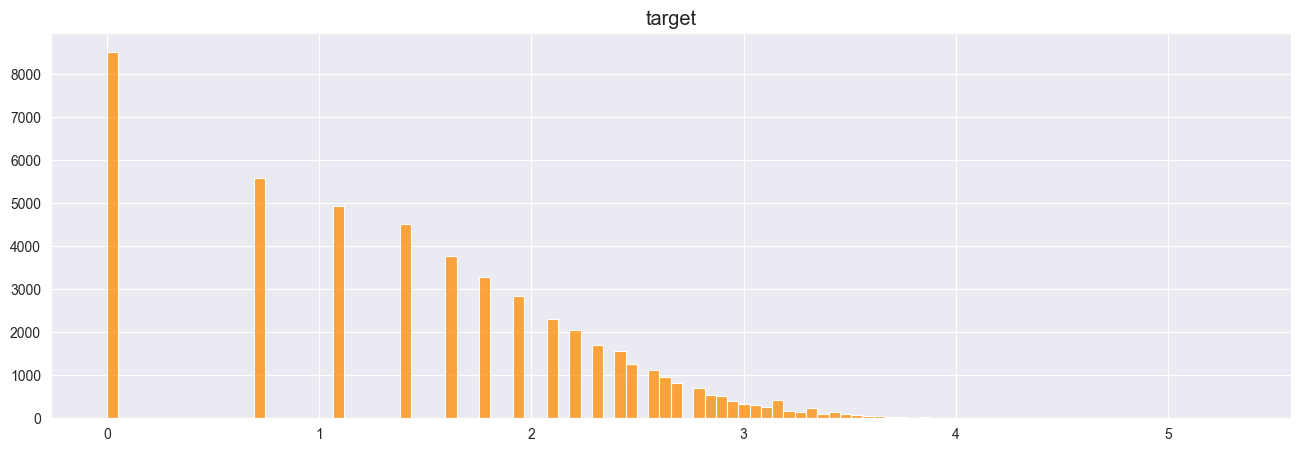

In [66]:
data['target'] = np.log1p(data['number_of_visits_23'])
data = data.drop('number_of_visits_23', axis=1)

drawHistplot('target', data)

##### Вывод  
Распределение таргето сильно зажато влево. Предпринят вариант логарифмирования переменной.

### Бинарные признаки

In [67]:
# Отбор признаков
bin_cols = []
for col in data.columns:
    if data[col].nunique() == 2:
        bin_cols.append(col)
bin_cols

['Gender', 'HasChronicDisease']

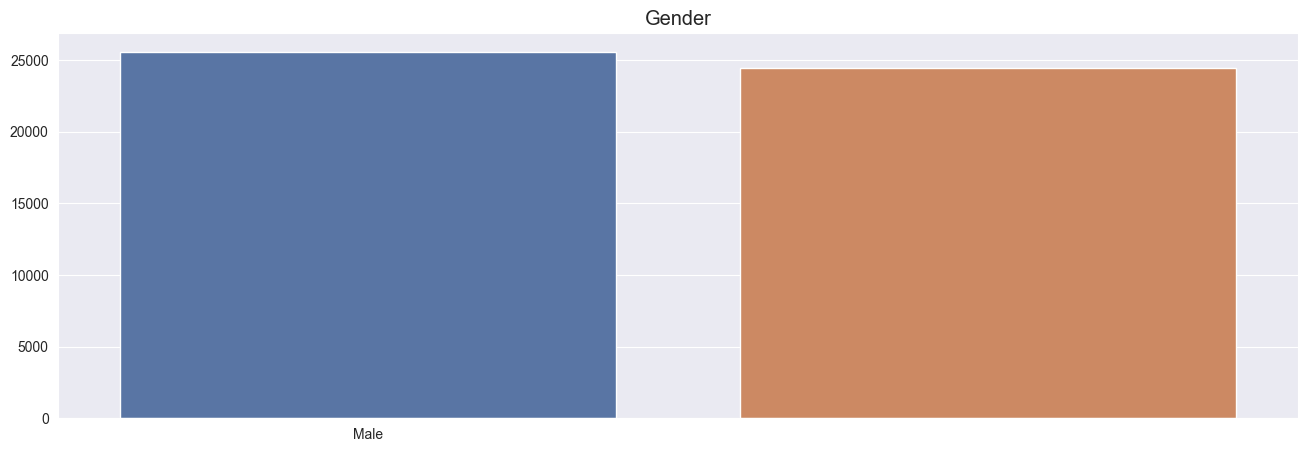

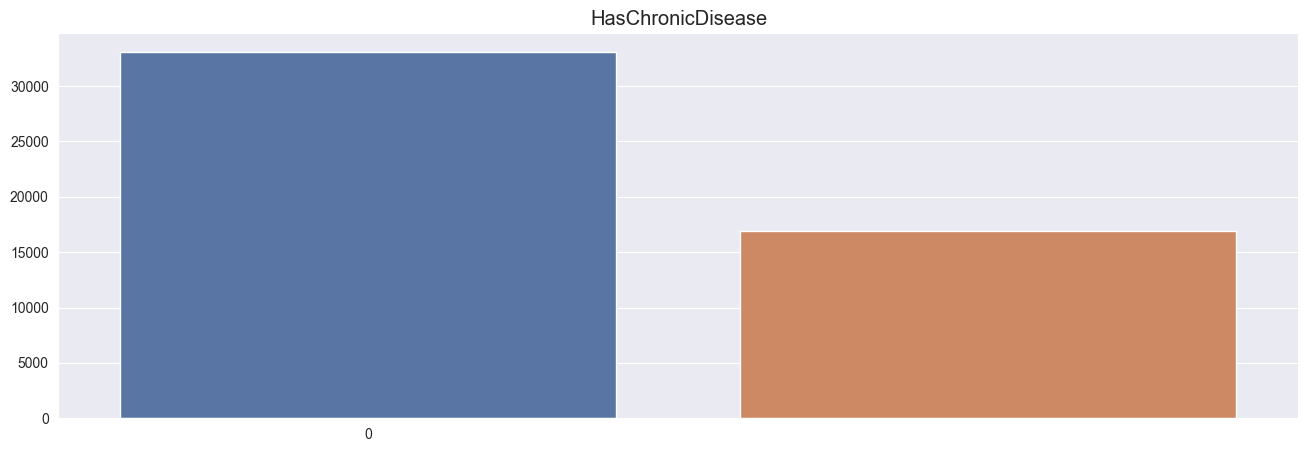

In [68]:
# Визуализация
[drawCountplot(col, data) for col in bin_cols];

In [69]:
# Перевод в категорию 1/0
data['Gender'] = np.where(data['Gender'] == 'Male', 1, 0)

In [70]:
# Проверка нулевой гипотезы об отстутствии различий в распределениях
u_test(data.loc[data['Gender'] == 0]['target'],
      data.loc[data['Gender'] == 1]['target']).pvalue > 0.05

False

In [71]:
# Проверка нулевой гипотезы об отстутствии различий в распределениях
u_test(data.loc[data['HasChronicDisease'] == 0]['target'],
      data.loc[data['HasChronicDisease'] == 1]['target']).pvalue > 0.05

False

##### Вывод:   
- два категориальных признака  
- распределение пола - равномерное
- перекос в наличии хронической болезни
- пол переведен в цифровую шкалу  
- для проверки выбран критерий Манна-Уитни, т.к. распределение не является нормальным
- проверка u_testом показала, что имеются различия в распределениях
- оба признака остается в сете  

### Категориальные признаки

In [72]:
# Отбор признаков
rest_cols = list(set(data.columns) ^ set(bin_cols) ^ {'target'})
cat_cols = []
for col in rest_cols:
    #print(col,':', data[col].nunique())
    if data[col].nunique() < 10:
        cat_cols.append(col)
cat_cols

['Relation', 'Insured_Network', 'Nationality']

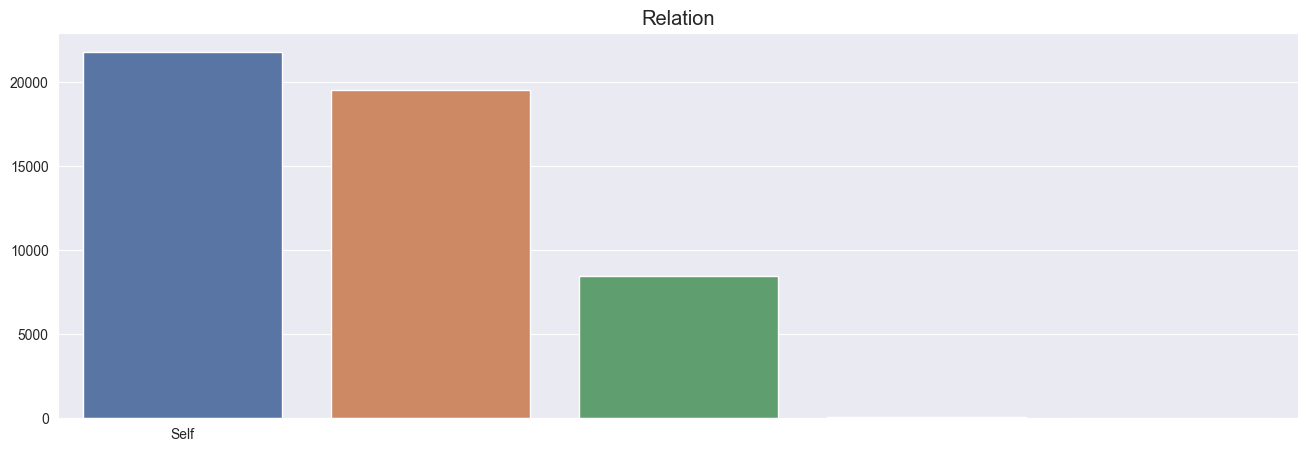

In [73]:
drawCountplot('Relation', data)

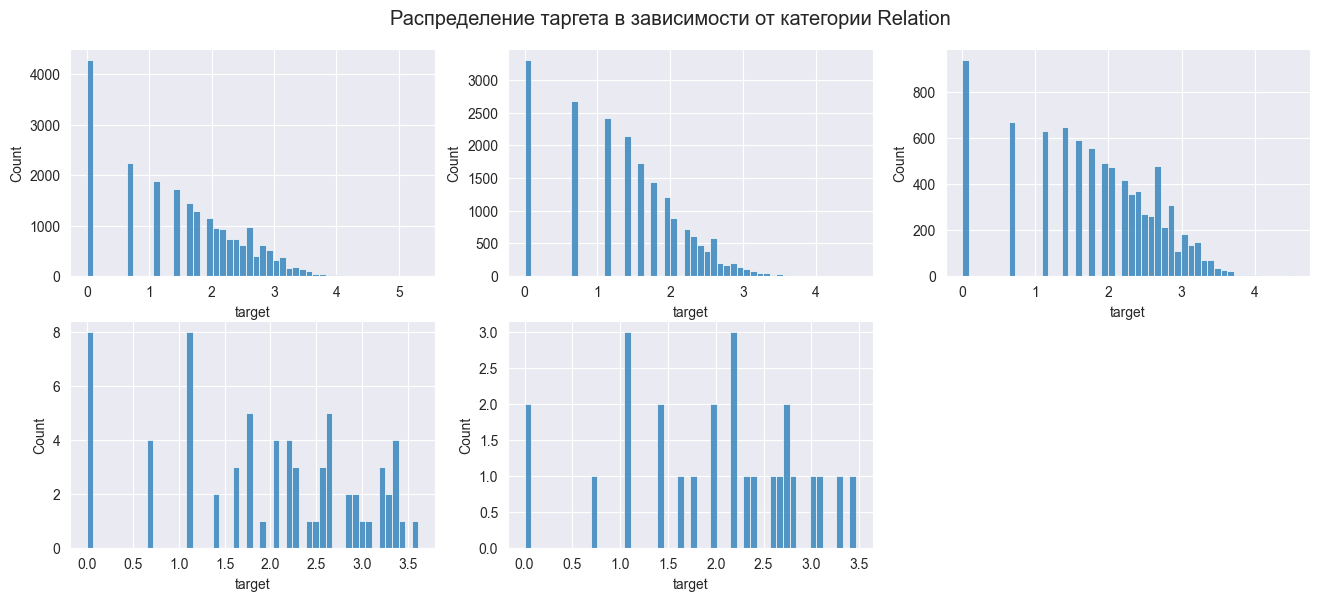

In [74]:
drawSomeHistplots('Relation')

In [75]:
kruskal_test('Relation', data)

Краскел и Уоллес настоятельно рекомендуют использовать признак.


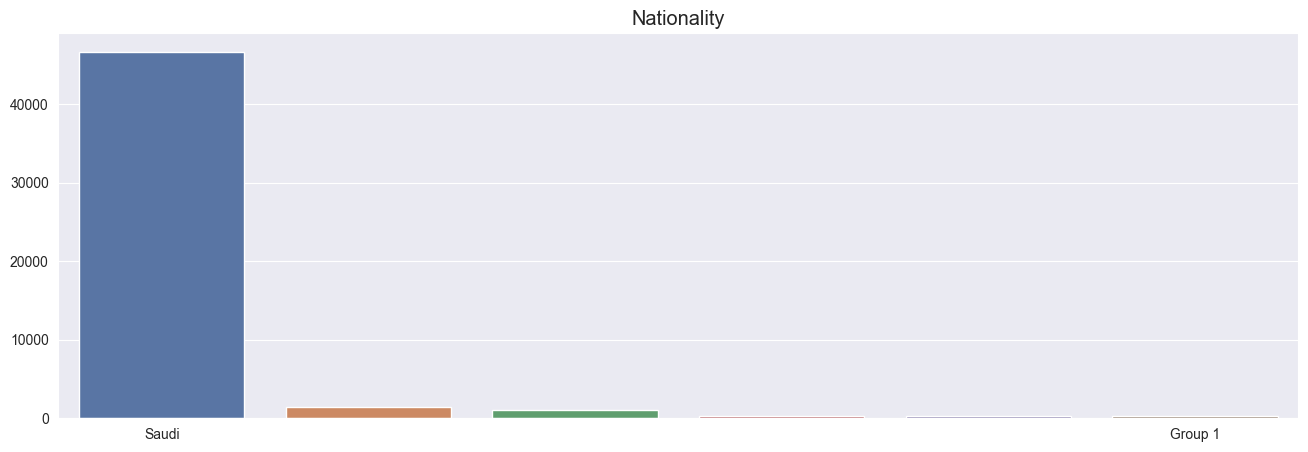

In [76]:
drawCountplot('Nationality', data)

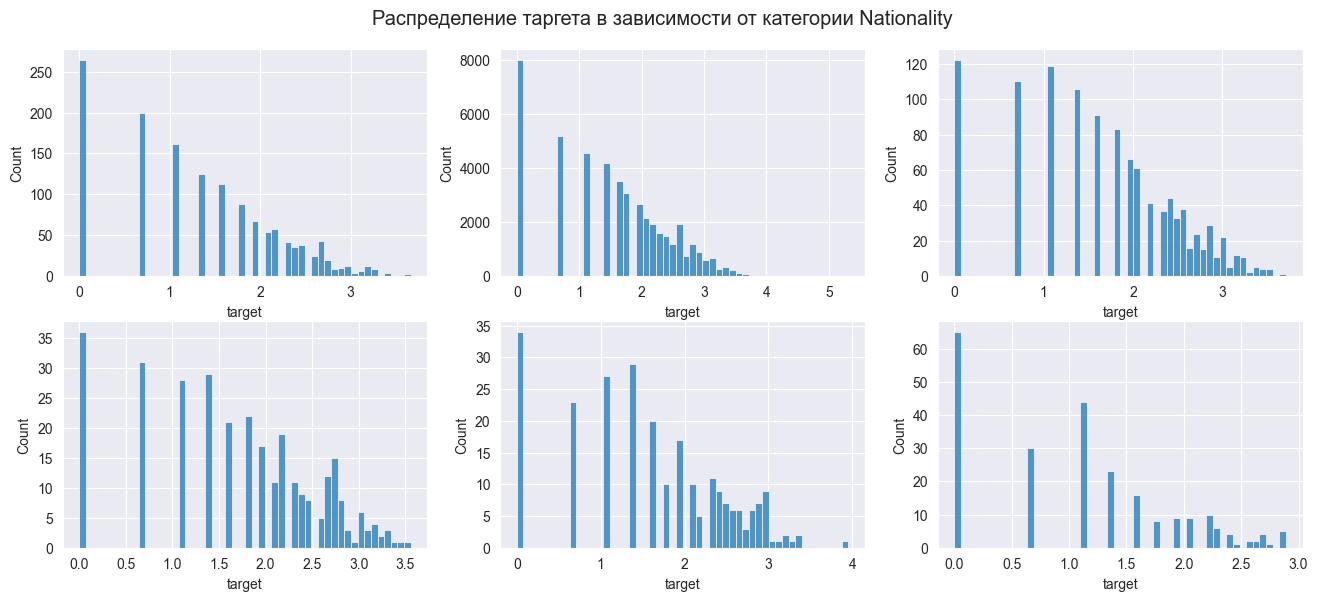

In [77]:
drawSomeHistplots('Nationality')

In [78]:
kruskal_test('Nationality', data)

Краскел и Уоллес настоятельно рекомендуют использовать признак.


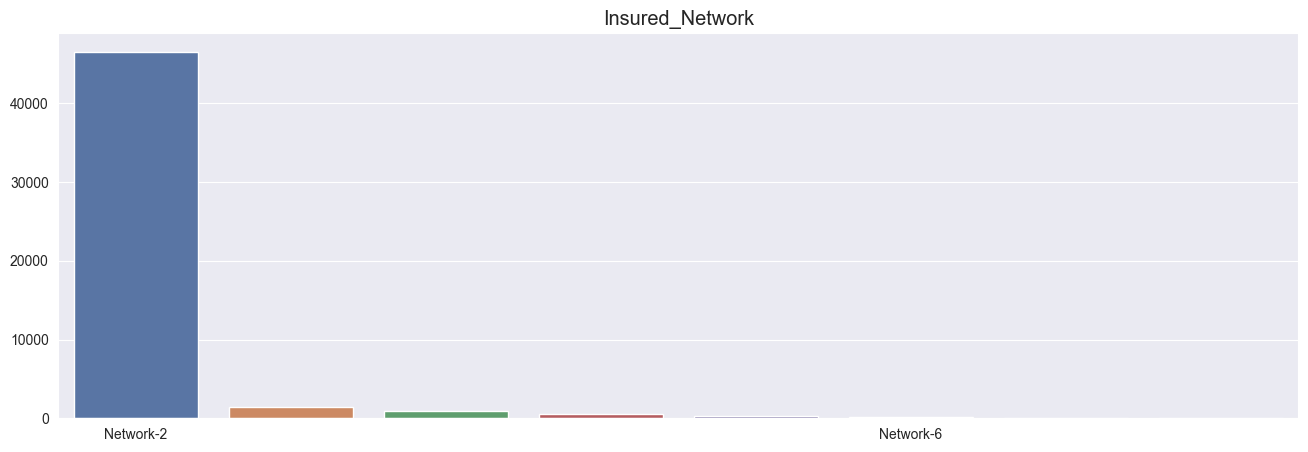

In [79]:
drawCountplot('Insured_Network', data)

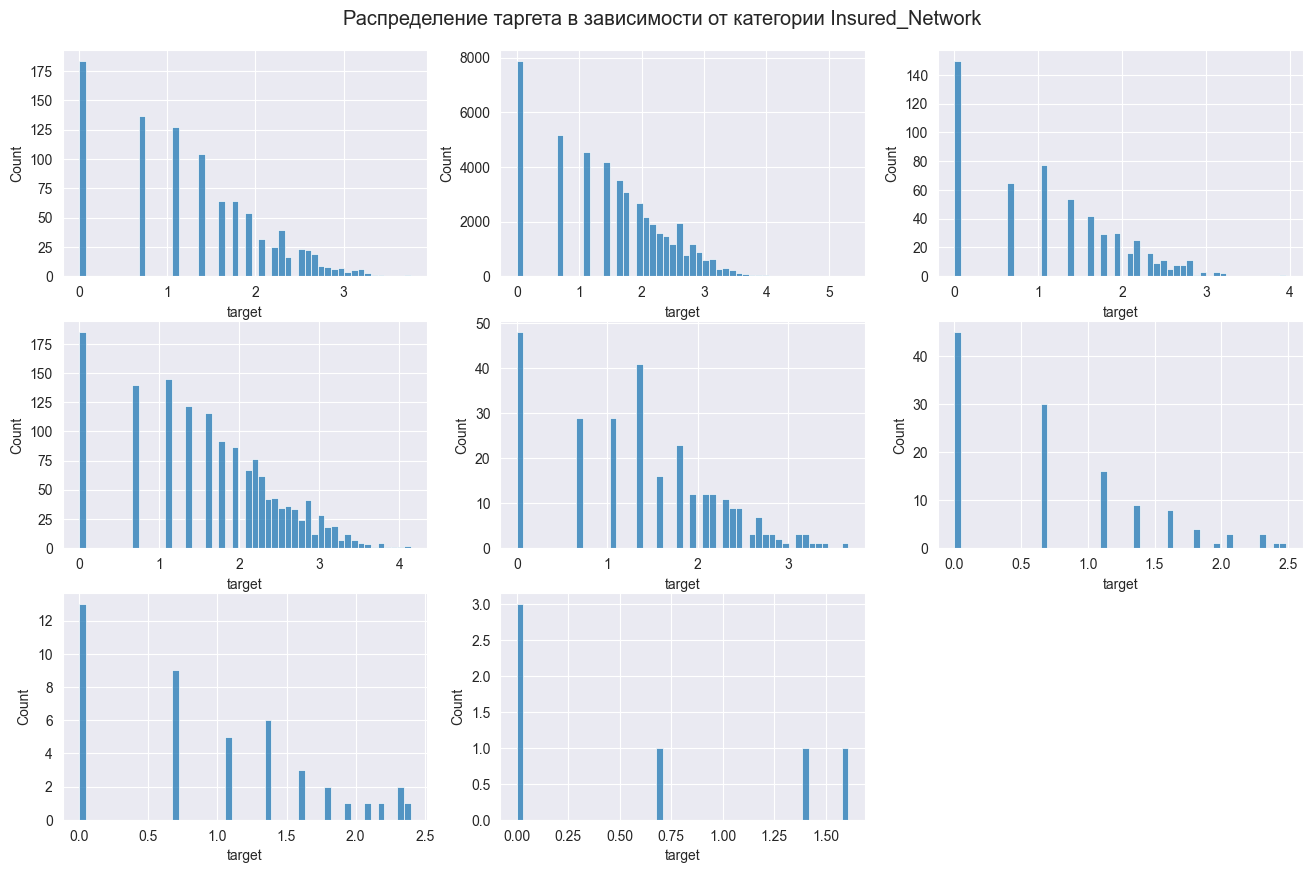

In [80]:
drawSomeHistplots('Insured_Network')

In [81]:
kruskal_test('Insured_Network', data)

Краскел и Уоллес настоятельно рекомендуют использовать признак.


##### Вывод: 
- три категориальных признака
- отдано предпочтение тесту Краскела-Уоллеса по причине ненормального распределения  
- проверка проказала, что имеются различия в распределениях  
- Все признаки остаются в сете

### Множественный признак

In [82]:
# Замена nan в диагнозе
data['Diagnoses'].fillna('WEL', inplace=True)

# Парсинг групп МКБ
try:
    with open('new_data.pkl', 'rb') as file:
        data = pickle.load(file)
    with open('new_cols.pkl', 'rb') as file:
        new_cols = pickle.load(file)
    print('загружено с диска')
    
except:
    new_cols = []
    url = 'https://classinform.ru/mkb-10.html'
    headers = {
        'Host': 'classinform.ru',
        'User-Agent': 'Safari',
        'Accept': '*/*',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive'
    }
    request = requests.get(url, headers=headers)

    soup = bs(request.text, parser='html.parser')

    divs = soup.select_one('div[id=cont_txt]')
    hrefs = divs.find_all('a')

    for i in range(0,len(hrefs),2):
        new_cols.append('_'.join(hrefs[i].text[-8:-1].split('-')))

    new_cols += ['UNK_UNK', 'WEL_WEL']
    
    
    data[new_cols] = 0

    # Заполнение МБК
    classify_it(data, new_cols)

    # Удаление родительского признака
    data.drop('Diagnoses', axis=1, inplace=True)
    
    with open('new_data.pkl', 'wb') as file:
        pickle.dump(data, file)
        
    with open('new_cols.pkl', 'wb') as file:
        pickle.dump(new_cols, file)
    print('Прокрутилось О*3..')  

загружено с диска


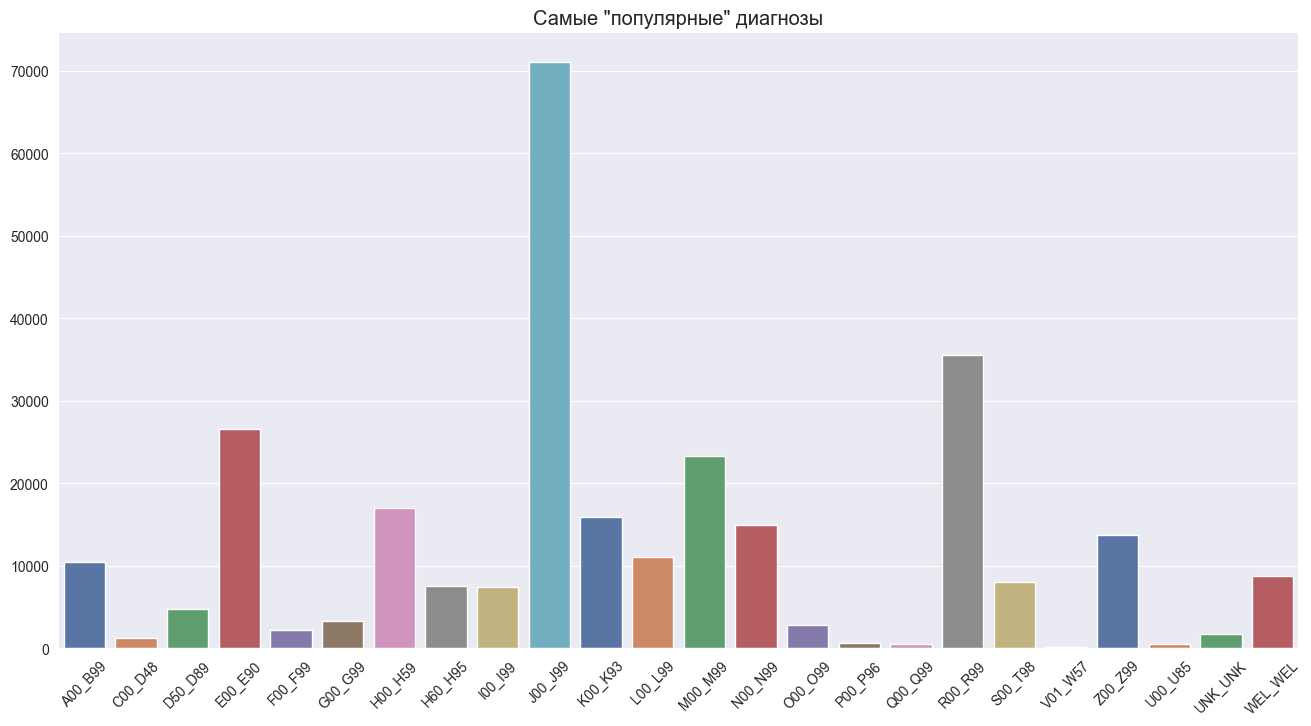

In [83]:
# Визуализация "популярных" диагнозов
plt.figure(figsize=(16,8))
sns.barplot(x=new_cols, 
            y=data[new_cols].sum(), 
            palette='deep') \
            .set_title('Самые "популярные" диагнозы', 
                                        fontsize='x-large')
plt.ylabel('')
plt.xticks(rotation=45);

In [84]:
# Пропуски
data[new_cols].isna().sum().sum()

0

##### Вывод: 
- Из открытых источников взят МБК-10.  
- Признак Диагнозы распакован на несколько категорий  
- Выявлены самые частые причины обращений клиентов:
    - Болезни органов дыхания
    - Симптомы, признаки и отклонения от нормы, выявленные при клинических и лабораторных исследованиях, не классифицированные в других рубриках
    - Болезни эндокринной системы, расстройства питания и нарушения обмена веществ

### Временной признак

In [85]:
# Удаление записи с пропуском в дате рождения
data.dropna(subset='DoB', axis=0, inplace=True)

# Генерация признака год рождения
data['YoB'] = data['DoB'].dt.year

# Удаление родительского признака
data.drop(['DoB'], axis=1, inplace=True)

ord_cols = ['YoB']
rest_cols += ['YoB']

data[['target', 'YoB']].corr('spearman')

,target,YoB
target,1.000000,-0.024004
YoB,-0.024004,1.000000


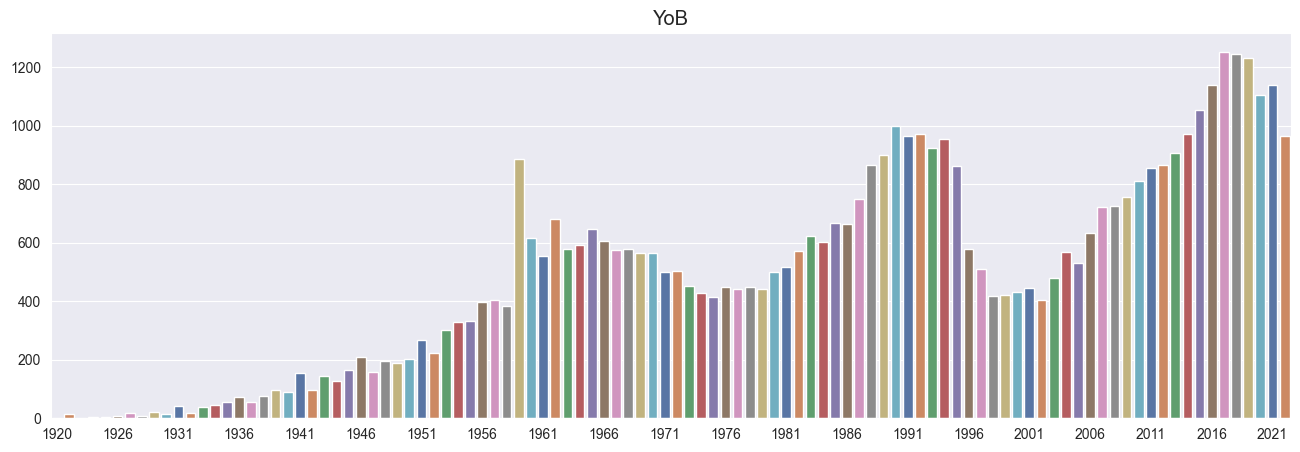

In [86]:
drawCountplot('YoB', data, squeeze_ticks=5, need_sort=False)

##### Вывод: 
- удален пропуск
- из признака вычленен год рождения клиента
- исходный признак удален

### Числовые признаки

In [87]:
# Отбор признаков
num_cols = list(set(rest_cols) ^ set(cat_cols) ^ {'Diagnoses', 'DoB'} ^ set(ord_cols))
data[num_cols].isna().sum()

number_of_services_22    0
Exposition_22            0
Exposition_23            0
number_of_visits_22      0
dtype: int64

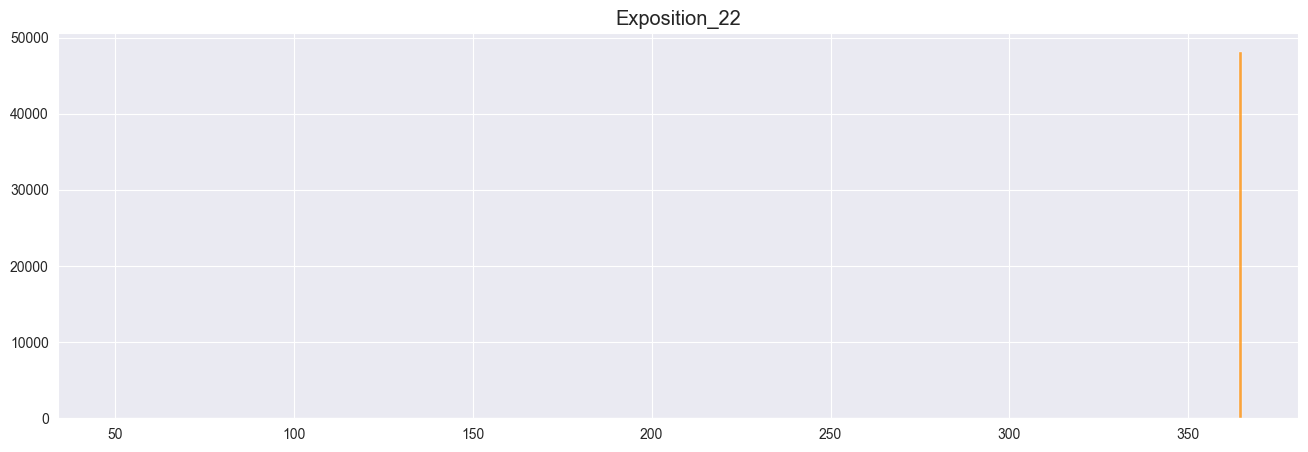

In [88]:
drawHistplot('Exposition_22', data, 365)

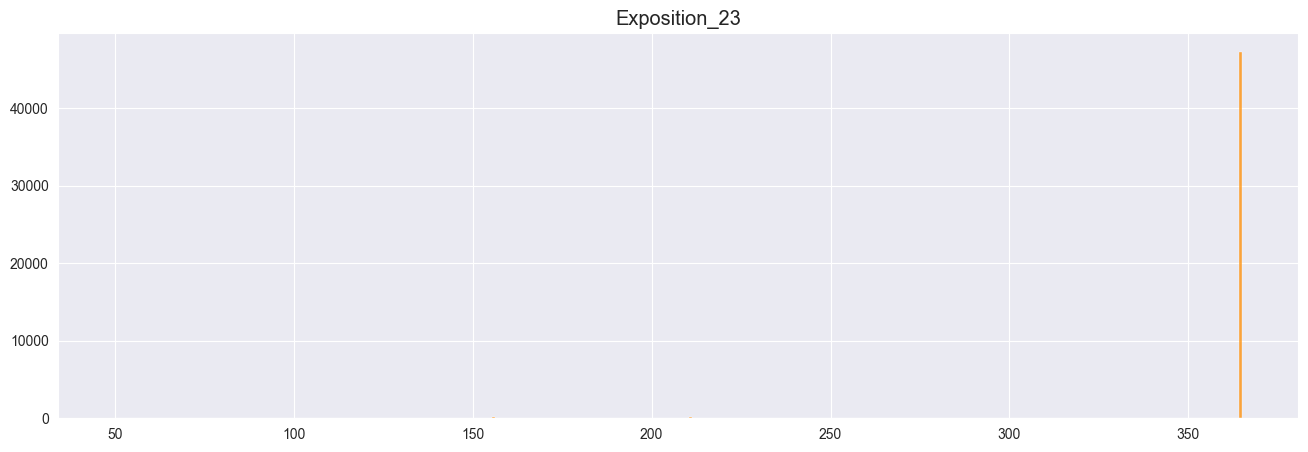

In [89]:
drawHistplot('Exposition_23', data, 365)

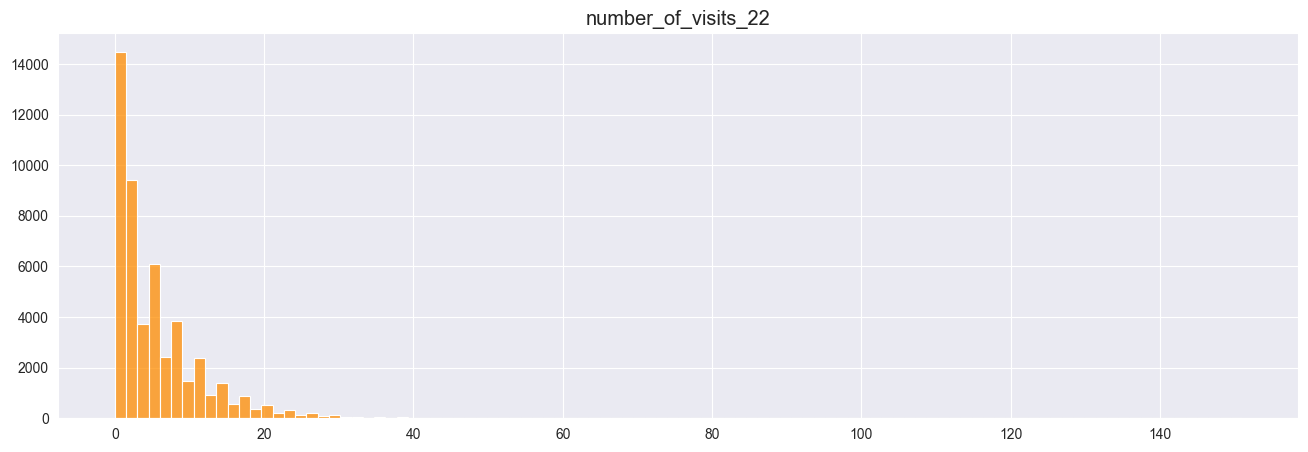

In [90]:
drawHistplot('number_of_visits_22', data)

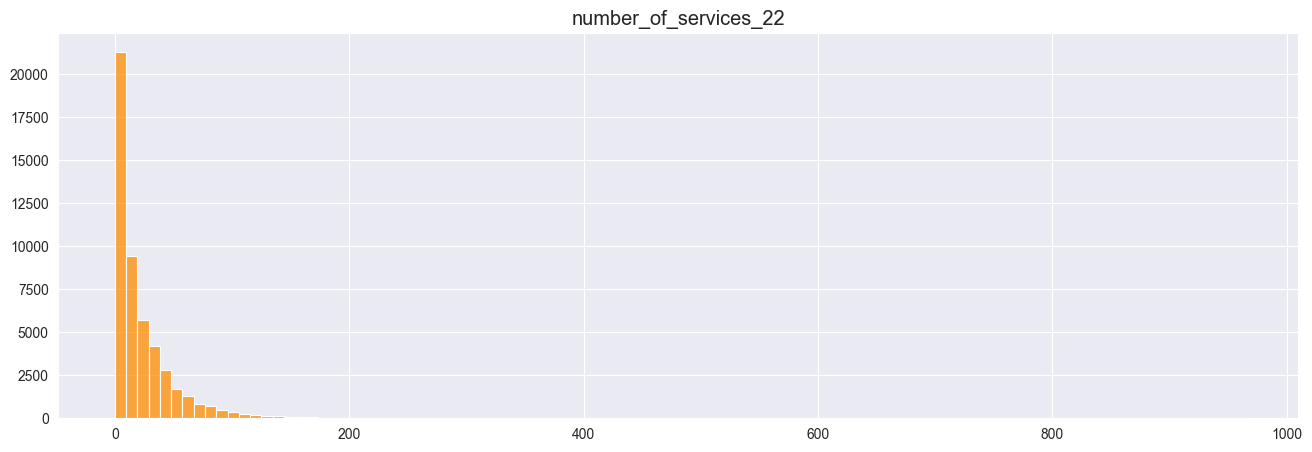

In [91]:
drawHistplot('number_of_services_22', data)

In [92]:
# Логарифмирование
for col in num_cols:
    data[f'{col}_log'] = np.log1p(data[col])
    
data = data.drop(num_cols, axis=1)

for idx in range(len(num_cols)):
    num_cols[idx] = num_cols[idx] + '_log'
print(num_cols)

['number_of_services_22_log', 'Exposition_22_log', 'Exposition_23_log', 'number_of_visits_22_log']


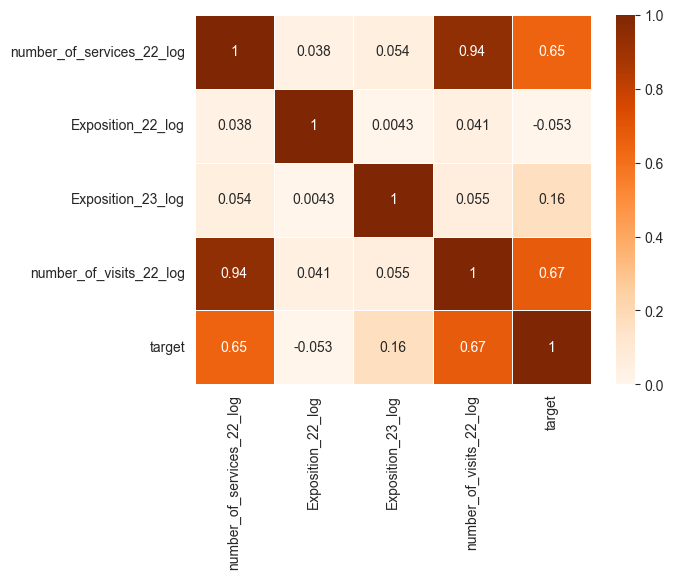

In [93]:
# корреляция Спирмена
sns.heatmap(data[num_cols+['target']].corr('spearman'), 
            annot=True, vmin=0, vmax=1, linewidths=0.5,
           cmap='Oranges');

In [94]:
# Генерация признака ожидаемого количества визитов в 23 году
data['rel_vis_log/exp_22_log'] = data['number_of_visits_22_log'] / np.log1p(data['Exposition_22_log'])
data['exp*rel'] = data['rel_vis_log/exp_22_log'] * data['Exposition_23_log']
data.drop(['number_of_services_22_log', 'Exposition_22_log', 'number_of_visits_22_log'], axis=1, inplace=True)

num_cols.remove('number_of_services_22_log')
num_cols.remove('Exposition_22_log')
num_cols.remove('number_of_visits_22_log')

num_cols += ['rel_vis_log/exp_22_log']
num_cols += ['exp*rel']

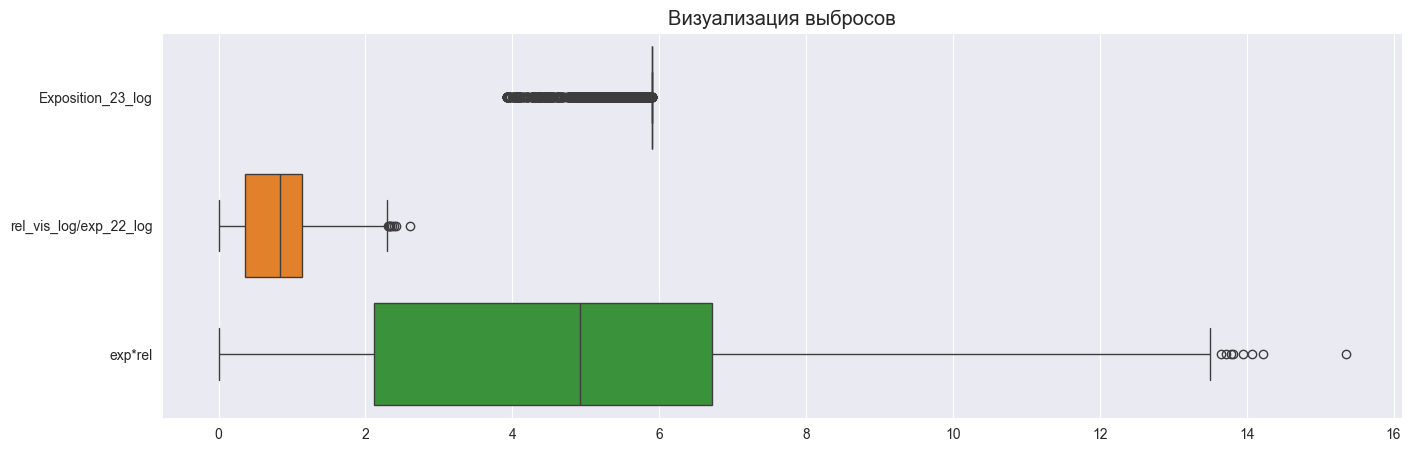

In [95]:
# Визуализация выбросов
plt.figure(figsize=(16,5))
sns.boxplot(data[num_cols], orient='h').set_title('Визуализация выбросов', fontsize='x-large');

In [96]:
# Сужение данных
for col in ['rel_vis_log/exp_22_log', 'exp*rel']:
    high = data[col].dropna().quantile(.975)
    low = data[col].dropna().quantile(.025)
    mean = data[col].dropna().mean()
    data.loc[data[col] > high, col] = high
    data.loc[data[col] < low, col] = low
    
num_cols += new_cols

##### Вывод:  
- Т.к. признаки сильно зажаты, принято решение логарифмировать их.    
- Корреляционный анализ проводился по методике Спирмена, т.к. распределения признаков не являются нормальными
- По результатам коррреляционного анализа выявлен один признак на удаление: количество услуг в 22 году, т.к. имеет сильную корреляцию с другим признаком, в тоже время меньше коррелирует с тартегом.  
- Сгенерирован признак ожидаемого количества визитов в 23 году.  
- Исходные признаки, из которых он появился - удалены.  
- Обработаны выбросы - значения выше/ниже 2.5% выборки приравнены к 2.5% /97.5% соответственно.  
- К числовым признакам добавлены признаки диагнозов

### Моделирование

In [97]:
# Разделение выборки
X = data.drop('target', axis=1)
y = data['target']

In [98]:
# Проверка на равенство признаков в списках и сете
assert X.shape[1] == (len(num_cols) + 
                      len(cat_cols) + 
                      len(bin_cols) + 
                      len(ord_cols)), 'Не равно!'

### LGBM

In [99]:
try:
    with open('lgbm.pkl', 'rb') as file:
        search = pickle.load(file)

except:
    # Препроцессинговая обработка
    preprocessor = ColumnTransformer([
        ('numeric', QuantileTransformer(output_distribution='normal', 
                                        random_state=RS), num_cols),
        ('categoric', OneHotEncoder(sparse_output=False, 
                                   drop='first', handle_unknown='ignore'), cat_cols),
        ('ordinal', OrdinalEncoder(), ord_cols)
    ])

    # Настрока пайплана
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LGBMRegressor(random_state=RS,
                              force_col_wise=True,
                              early_stopping_rounds=10,
                              verbose=-1,
                              n_jobs=-1))
    ])

    # Выбор гиперпараметров
    param_grid = {
        'model__boosting_type': ['gbdt', 'dart', 'rf'],
        'model__num_leaves': [n for n in range(5, 100, 5)], 
        'model__n_estimators': [n for n in range(200, 1000, 200)],
        'model__max_depth': [n for n in range(1, 11, 1)],
        'model__learning_rate': [n for n in np.arange(0.5, 1, 0.01)],
        'model__reg_alpha': [n for n in np.arange(0.01, 1, 0.02)],
        'model__reg_lambda': [n for n in np.arange(0.01, 1, 0.02)]
    }

    # Перебор ГП
    search = RandomizedSearchCV(pipe, param_grid, 
                                   n_jobs=-1, cv=5,
                                   n_iter = 10,
                                   random_state=RS, 
                                   scoring='neg_mean_squared_error')


    search.fit(X,y)

    with open('lgbm.pkl', 'wb') as file:
        pickle.dump(search, file)
print(f'Результат на кросс-валидации {-search.best_score_:.5f})')
print(f'Лучшие гиперпараметры модели: {search.best_params_}')


Результат на кросс-валидации nan)
Лучшие гиперпараметры модели: {'model__reg_lambda': 0.5499999999999999, 'model__reg_alpha': 0.8699999999999999, 'model__num_leaves': 85, 'model__n_estimators': 400, 'model__max_depth': 5, 'model__learning_rate': 0.8900000000000003, 'model__boosting_type': 'dart'}


In [100]:
# Проверка на всей треннинговой выборке 
y_hat = search.best_estimator_.predict(X)
y_hat = np.expm1(y_hat)
y = np.expm1(y)

y_hat = np.round(y_hat,0)

In [103]:
print(f'Средняя квадратичная ошибка составила: {MSE(y_hat, y):.2f}')
print(f'Качество модели: {r2(y, y_hat):.2f}')

Средняя квадратичная ошибка составила: 19.81
Качество модели: 0.58


In [43]:
# Создание таблицы признаков
feature_importance = pd.Series(search
                               .best_estimator_
                               .named_steps['preprocessor']
                               .get_feature_names_out()) \
                               .to_frame(name='feature')

# Добавление значений
feature_importance['value'] = pd.Series(search
                                        .best_estimator_[1]
                                        .feature_importances_)
# Сортировка
feature_importance.sort_values(by='value', 
                               ascending=False, inplace=True)

# Сброс индексации
feature_importance.reset_index(drop=True, inplace=True)

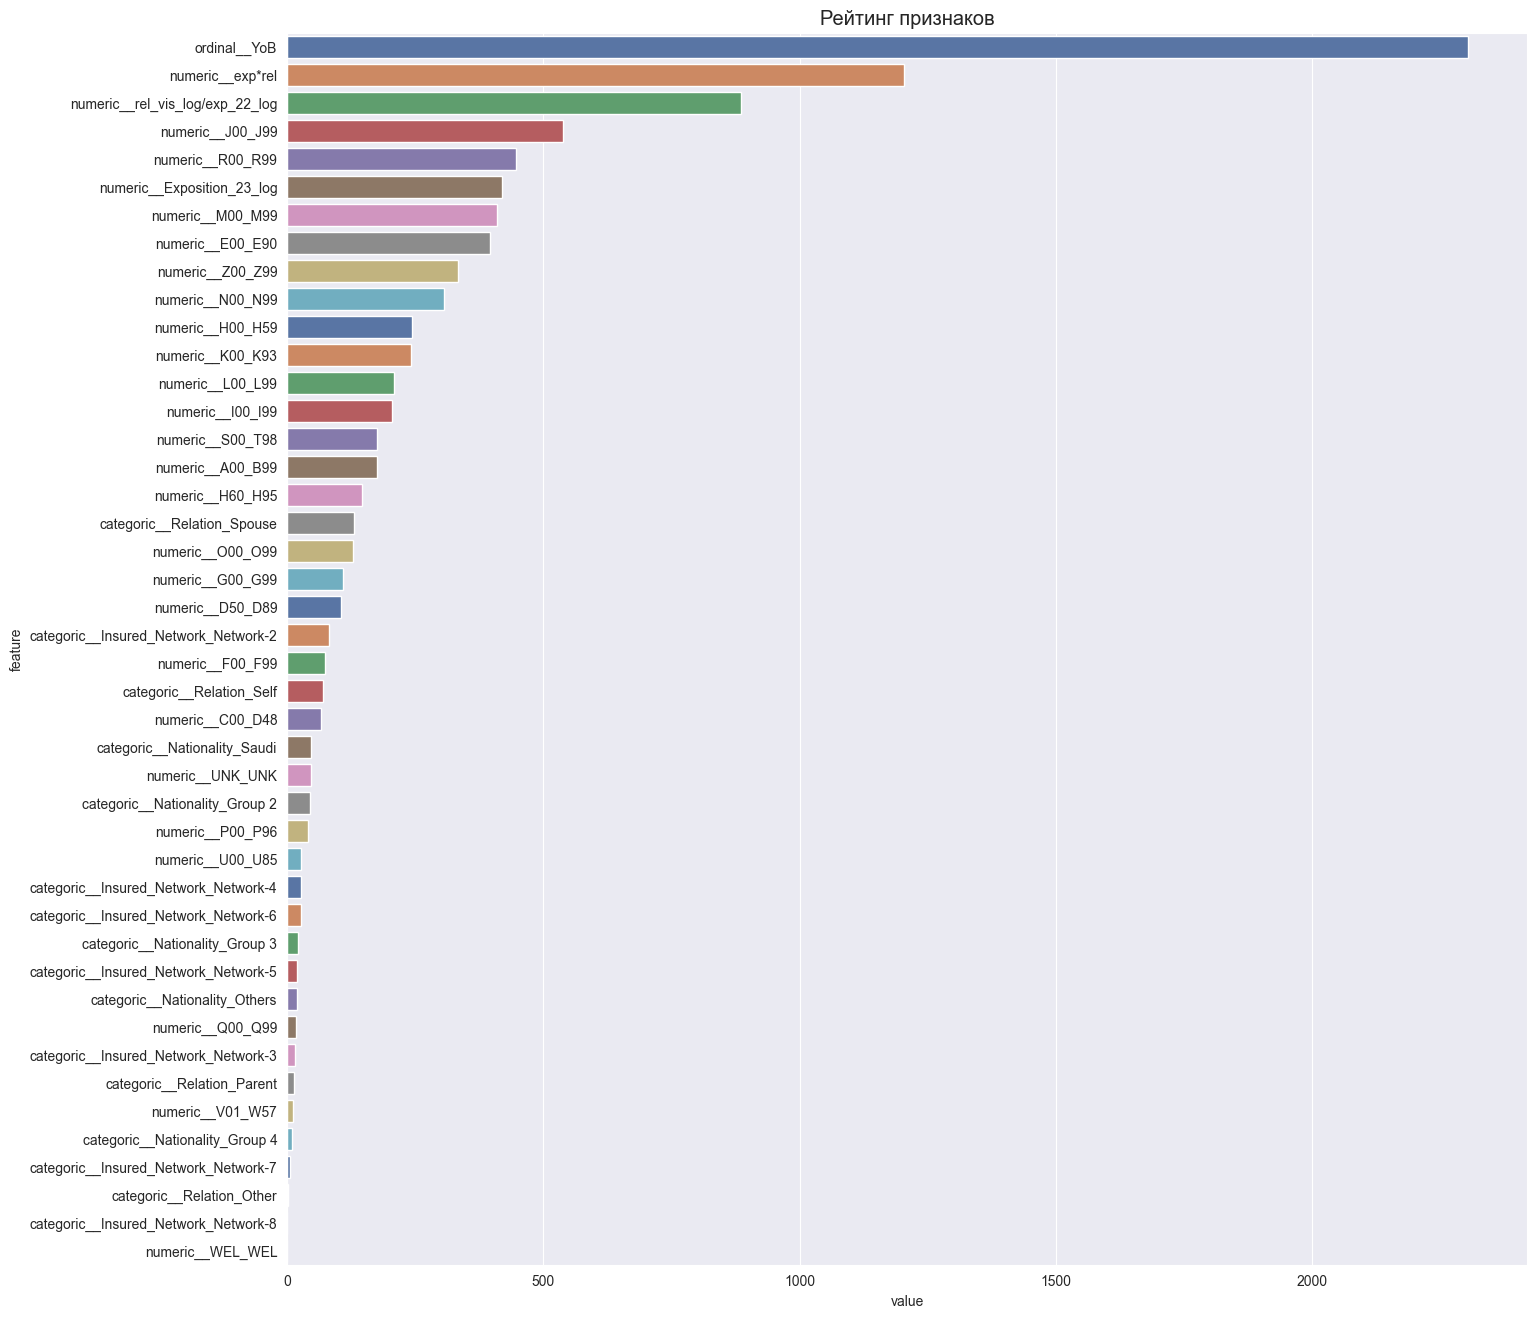

In [44]:
plt.figure(figsize=(16,16))
sns.barplot(x=feature_importance['value'], 
            y=feature_importance['feature'],
            palette='deep').set_title('Рейтинг признаков', 
                                      fontsize='x-large');

# Запись в файл
feature_importance.to_csv('feature_importance.csv')

##### Вывод:   
- Для обработки признаков использованы:   
    - OneHotEncoder - категориальные  
    - QuantileTransformer - числовые 
    - OrdinalEncoder - порядковые (год рождения)  
- Собран пайплайн из препроцессора и модели  
- В качестве модели использовался LightGBM
- Перебор ГП осуществлен с помощью  RandomizedSearchCV  
- Проведена проверка на КВ и оценка по всей трейновой выборке  
- Предсказание и таргет переведены обратно.
- Сформирован график важности признаков. 

Точночть модели на тренировочной выборке составила 19.81 при доле объясненной дисперсии - 0.58

# Отложенная выборка

In [45]:
X_test = pd.read_excel('datasets/ML_holdout.xlsx', index_col=[0])
get_info(X_test)

Основные показатели датасета:
----------------------------------------
Количество признаков: 11
----------------------------------------
Количество сэмплов: 10000
----------------------------------------

Пример данных:


,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23
Insured_PIN,,,,,,,,,,,
1516424,Network-2,Saudi,Female,Child,2012-09-06,A09,0,365,1,3,365
22210474,Network-1,Saudi,Female,Child,1995-10-26,T78.4;R50.9;Z01.8;R05,0,365,4,22,365
1518945,Network-2,Saudi,Female,Spouse,1962-11-28,D64.9;J06;H04.1;M13.9,0,365,5,11,365


----------------------------------------

Описание данных:


,count,mean,min,25%,50%,75%,max,std
DoB,10000,1990-02-05 12:24:02.880000128,1922-02-13 00:00:00,1970-09-01 18:00:00,1991-11-09 12:00:00,2011-02-19 06:00:00,2022-11-12 00:00:00,NaN
HasChronicDisease,10000.0,0.338,0.0,0.0,0.0,1.0,1.0,0.473052
Exposition_22,10000.0,359.4261,50.0,365.0,365.0,365.0,365.0,33.756826
number_of_visits_22,10000.0,5.8236,0.0,1.0,4.0,8.0,113.0,6.789425
number_of_services_22,10000.0,22.9913,0.0,3.0,13.0,31.0,495.0,30.820412
Exposition_23,10000.0,355.0386,50.0,365.0,365.0,365.0,365.0,45.307745


----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1516424 to 1384402
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_Network        10000 non-null  object        
 1   Nationality            10000 non-null  object        
 2   Gender                 10000 non-null  object        
 3   Relation               10000 non-null  object        
 4   DoB                    10000 non-null  datetime64[ns]
 5   Diagnoses              8274 non-null   object        
 6   HasChronicDisease      10000 non-null  int64         
 7   Exposition_22          10000 non-null  int64         
 8   number_of_visits_22    10000 non-null  int64         
 9   number_of_services_22  10000 non-null  int64         
 10  Exposition_23          10000 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 937.5+ KB
---------

In [46]:
X_test

,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23
Insured_PIN,,,,,,,,,,,
1516424,Network-2,Saudi,Female,Child,2012-09-06,A09,0,365,1,3,365
22210474,Network-1,Saudi,Female,Child,1995-10-26,T78.4;R50.9;Z01.8;R05,0,365,4,22,365
1518945,Network-2,Saudi,Female,Spouse,1962-11-28,D64.9;J06;H04.1;M13.9,0,365,5,11,365
1344077,Network-2,Saudi,Male,Child,2003-07-09,J06.9;J06.8;J02;G44.0;M25.5;R51;E55;L03,1,365,9,30,365
1354276,Network-2,Saudi,Female,Spouse,1995-07-22,UNKRC;N64;A09,0,365,3,10,365
...,...,...,...,...,...,...,...,...,...,...,...
3948786,Network-2,Saudi,Female,Child,2022-04-16,E55.9;F98.2;R05;K59.0;O92.41;J20;J06.9;J06;R14...,1,260,7,12,365
67038285,Network-1,Saudi,Male,Self,1979-12-27,J01.9;S05.0;J45;K29;E78;E78.5;J02;E11,1,365,10,17,365
1371592,Network-2,Saudi,Female,Self,1952-03-26,R50.0;R05,0,365,2,8,365


In [47]:
# Перевод в категорию 1/0
X_test['Gender'] = np.where(X_test['Gender'] == 'Male', 1, 0)  

# Замена nan в диагнозе
X_test['Diagnoses'].fillna('WEL', inplace=True)  

# with open('new_cols.pkl', 'rb') as file:
#     new_cols = pickle.load(file)
X_test[new_cols] = 0


In [48]:
# Заполнение МБК
classify_it(X_test, new_cols)

# Удаление родительского признака
X_test.drop('Diagnoses', axis=1, inplace=True)

# Удаление записи с пропуском в дате рождения
X_test.dropna(subset='DoB', axis=0, inplace=True)

# Генерация признака год рождения
X_test['YoB'] = X_test['DoB'].dt.year

# Удаление родительского признака
X_test.drop(['DoB'], axis=1, inplace=True)

num_cols = ['number_of_visits_22',
 'Exposition_22',
 'Exposition_23',
 'number_of_services_22']

# Логарифмирование
for col in num_cols:
    X_test[f'{col}_log'] = np.log1p(X_test[col])
    
X_test = X_test.drop(num_cols, axis=1)

for idx in range(len(num_cols)):
    num_cols[idx] = num_cols[idx] + '_log'

# Генерация признака ожидаемого количества визитов в 23 году
X_test['rel_vis_log/exp_22_log'] = X_test['number_of_visits_22_log'] / np.log1p(X_test['Exposition_22_log'])
X_test['exp*rel'] = X_test['rel_vis_log/exp_22_log'] * X_test['Exposition_23_log']
X_test.drop(['number_of_services_22_log', 'Exposition_22_log', 'number_of_visits_22_log'], axis=1, inplace=True)

# Сужение данных
for col in ['rel_vis_log/exp_22_log', 'exp*rel']:
    high = X_test[col].dropna().quantile(.975)
    low = X_test[col].dropna().quantile(.025)
    mean = X_test[col].dropna().mean()
    X_test.loc[X_test[col] > high, col] = high
    X_test.loc[X_test[col] < low, col] = low
    
    

In [49]:
# Предсказание
y_hat = pd.Series(search.best_estimator_.predict(X_test), index=X_test.index)

# Ковертация
y_hat = np.expm1(y_hat)
y_hat = np.round(y_hat,0)

In [50]:
# Запись в файл
y_hat.to_csv('y_hat.csv')